## Setup and Imports

In [31]:
import os
import shutil
import numpy as np
import torch
from datasets import Dataset
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from transformers.image_utils import load_image
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)
from pathlib import Path
from functools import partial
import evaluate
from PIL import Image
import json
import time
from transformers.trainer_utils import EvalPrediction
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [4]:
SEED = 27

## Dataset

In [5]:
# workdir = "data/fashion_mnist"

# # Define transformations (convert images to tensors and normalize if needed)
# transform = transforms.ToTensor()

# # Download the FashionMNIST dataset
# fashion_mnist = datasets.FashionMNIST(
#     root=".",  # Temporary directory to store the raw dataset
#     train=True,  # Download the training set
#     download=True,  # Download the dataset if not already present
#     transform=transform,
# )

# label_map = {0: "top", 1: "trouser"}

# # Save each image as a separate file
# for idx, (image, label) in enumerate(fashion_mnist):
#     if label > 1:
#         continue
#     # Convert the tensor image to a PIL image
#     pil_image = transforms.ToPILImage()(image)

#     # Create a subdirectory for each label (optional)
#     label_dir = os.path.join(workdir, str(label_map[label]))
#     os.makedirs(label_dir, exist_ok=True)

#     # Save the image to the corresponding label directory
#     image_path = os.path.join(label_dir, f"image_{idx}.png")
#     pil_image.save(image_path)


# print(f"All images saved to: {workdir}")

# shutil.rmtree("FashionMNIST")

In [6]:
# Create torch dataset, and then huggingfa
images_path = Path("./data/fashion_mnist/all")
classes = [fold.stem for fold in images_path.glob("*")]
print(classes)

['top', 'trouser']


In [7]:
label2id = {"top": 0, "trouser": 1}

# To transformers dataset
all_images = []
labels = []

with open("./data/fashion_mnist/fashion_mnist.jsonl", "w") as f:
    id_ = 0
    for class_ in classes:
        class_path = images_path / class_
        for img_path in class_path.glob("*.png"):
            new_path = shutil.copy2(img_path.as_posix(), images_path.parent / "images")
            all_images.append(new_path)
            labels.append(label2id[class_])

            f.write(json.dumps({"id": id_, "filename": img_path.name, "label": label2id[class_]}) + "\n")
            id_ += 1

# Create a Hugging Face Dataset
dataset = Dataset.from_dict({"image_path": all_images, "label": labels})

In [8]:
# Step 1: Perform train-test split
tv_test_split = dataset.train_test_split(test_size=0.25, seed=SEED)

# Add validation split
train_val_split = tv_test_split["train"].train_test_split(test_size=tv_test_split["test"].num_rows, seed=SEED)

train_set = train_val_split["train"]
validation_set = train_val_split["test"]
test_set = tv_test_split["test"]

splits_dict = {
    "validation": [Path(img["image_path"]).name for img in validation_set],
    "test": [Path(img["image_path"]).name for img in test_set],
}

In [9]:
# Write split to file
with open("./data/fashion_mnist/splits.json", "w") as f:
    json.dump(splits_dict, f)

In [10]:
print(f"Number of training examples: {len(train_set)}")
print(f"Number of validation examples: {len(validation_set)}")
print(f"Number of test examples: {len(test_set)}")

Number of training examples: 6000
Number of validation examples: 3000
Number of test examples: 3000


In [11]:
labels = classes
num_labels = len(labels)
print(f"Number of labels: {num_labels}")

# Build the dictionaries for easier query
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[i] = label

Number of labels: 2


In [12]:
label2id

{'top': '0', 'trouser': '1'}

In [13]:
id2label

{0: 'top', 1: 'trouser'}

### Visualize the dataset

In [14]:
def display_image_grid(images, labels, rows=2, cols=5, figsize=(12, 6), target_size=(128, 128), after_aug=False):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if after_aug:
            image = images[i]
            image = image.permute(1, 2, 0)
            image = image.clip(min=0.0, max=1.0)
        else:
            image = images[i].resize((128, 128))
        ax.imshow(image)
        ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

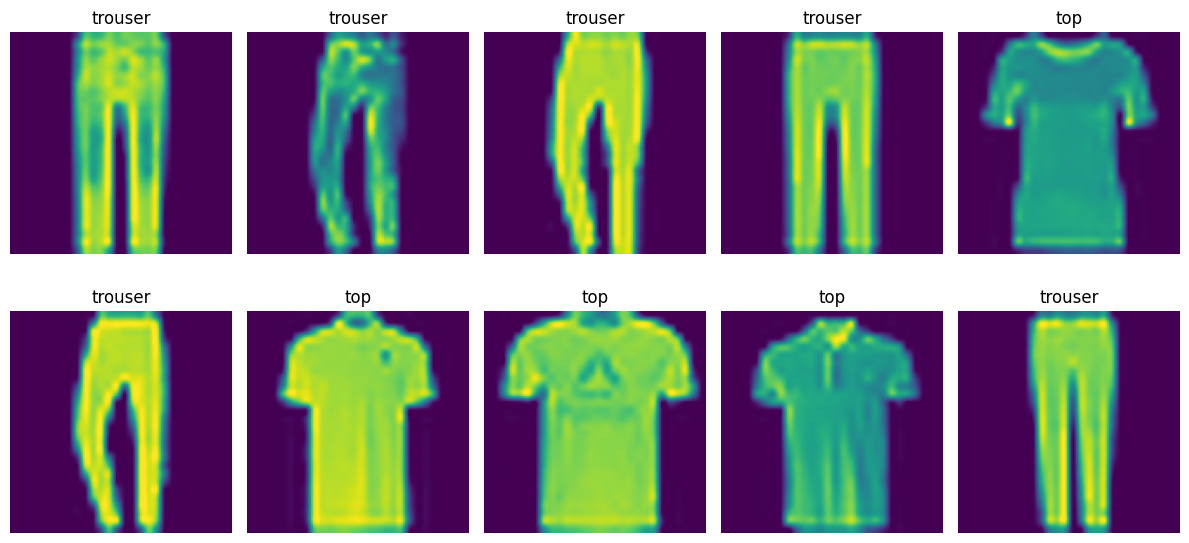

In [15]:
samples = train_set.shuffle().select(range(10))
sample_images = [Image.open(img_path) for img_path in samples["image_path"]]
sample_labels = [id2label[label] for label in samples["label"]]
display_image_grid(sample_images, sample_labels)

## Dataset Transforms for Traning

In [ ]:
# Load a pre-trained model from Hugging Face Hub
model_path = "./models/resnet18.a1_in1k"

image_processor = AutoImageProcessor.from_pretrained(model_path)


# checkpoint = "timm/resnet18.a1_in1k"
# model = AutoModelForImageClassification.from_pretrained(checkpoint)
# model.save_pretrained(model_path)


In [17]:
train_transforms = image_processor.train_transforms
val_transforms = image_processor.val_transforms


def apply_transforms(examples, train_aug=False):
    if train_aug:
        examples["pixel_values"] = [train_transforms(Image.open(img).convert("RGB")) for img in examples["image_path"]]
    else:
        examples["pixel_values"] = [val_transforms(Image.open(img).convert("RGB")) for img in examples["image_path"]]

    del examples["image_path"]
    return examples

In [18]:
train_ds = train_set.with_transform(partial(apply_transforms, train_aug=True))
test_ds = test_set.with_transform(apply_transforms)
val_ds = validation_set.with_transform(apply_transforms)

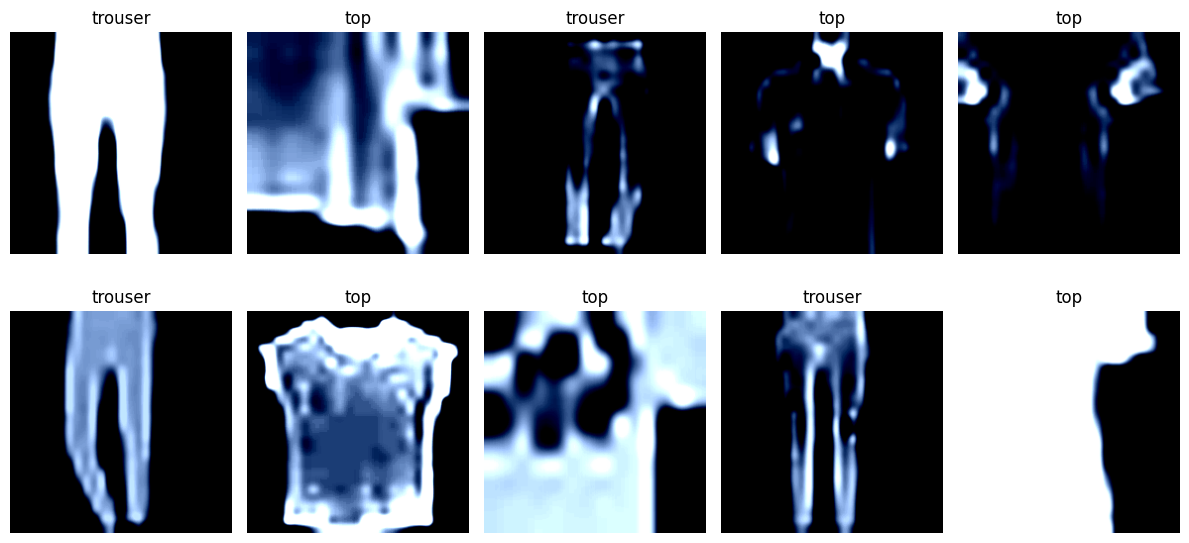

In [19]:
samples = train_ds.shuffle().select(range(10))
sample_images = [s["pixel_values"] for s in samples]
sample_labels = [id2label[s["label"]] for s in samples]

# After augmentation
display_image_grid(sample_images, sample_labels, after_aug=True)

## Model

In [20]:
model = AutoModelForImageClassification.from_pretrained(
    model_path,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of TimmWrapperForImageClassification were not initialized from the model checkpoint at ./models/resnet18.a1_in1k and are newly initialized because the shapes did not match:
- fc.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- fc.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [22]:
def compute_metrics(pred: EvalPrediction):
    # Extract predictions and labels
    predictions = np.argmax(pred.predictions, axis=1)  # Get the predicted class
    labels = pred.label_ids

    # Compute metrics (e.g., accuracy, precision, recall, F1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    # Return a dictionary of metrics
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [21]:
learning_rate = 1e-5
batch_size = 128
num_epochs = 5
output_dir = "models/checkpoints"

In [ ]:
data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir=output_dir,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    warmup_ratio=0.2,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.331400,0.644545,0.829333,0.829685,0.829333,0.829297
2,0.313400,0.598462,0.869000,0.881695,0.869000,0.867939
3,0.303200,0.572381,0.909667,0.912835,0.909667,0.909505
4,0.598700,0.557818,0.930667,0.931319,0.930667,0.930644


The `save_pretrained` method is disabled for TimmWrapperImageProcessor. The image processor configuration is saved directly in `config.json` when `save_pretrained` is called for saving the model.


TrainOutput(global_step=115, training_loss=0.6164842569309732, metrics={'train_runtime': 277.9627, 'train_samples_per_second': 107.928, 'train_steps_per_second': 0.414, 'total_flos': 2.913876981000438e+17, 'train_loss': 0.6164842569309732, 'epoch': 4.808510638297872})

In [25]:
trainer.evaluate()

{'eval_loss': 0.5578182339668274,
 'eval_accuracy': 0.9306666666666666,
 'eval_precision': 0.9313185550695924,
 'eval_recall': 0.9306666666666666,
 'eval_f1': 0.9306443197184403,
 'eval_runtime': 7.9341,
 'eval_samples_per_second': 378.114,
 'eval_steps_per_second': 3.025,
 'epoch': 4.808510638297872}

In [26]:
# Save the trained model and tokenizer
output_dir = "./models/trained-model"
trainer.model.save_pretrained(output_dir)  # Save the model


## Inference on Test Data

In [27]:
image = load_image("data/fashion_mnist/images/image_1.png")
inputs = image_processor(image, return_tensors="pt")

In [28]:
with torch.no_grad():
    logits = model(**inputs).logits
    labels = logits.argmax(-1).item()

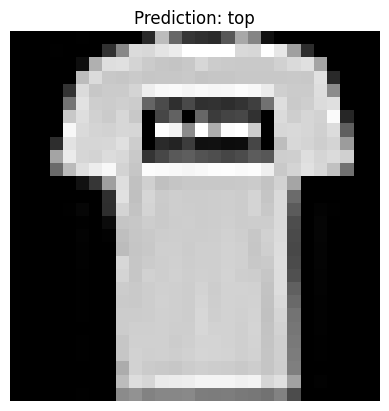

In [29]:
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {id2label[labels]}")
plt.show()

## Test optimised inference

In [33]:
output_dir

'./models/trained-model'

In [41]:
def measure_image_classification_inference_time_separate(
    image_paths: list[Path],
    model_name: str,  # Replace with your model
    batch_size=1,
    device=torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu",
):
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(model_name).to(device)
    model.eval()  # Set the model to evaluation mode

    total_inference_time = 0.0
    num_images = len(image_paths)

    with torch.no_grad():  # Disable gradient calculation for inference
        for i in range(0, num_images, batch_size):
            batch_paths = image_paths[i : i + batch_size]
            images = [Image.open(path).convert("RGB") for path in batch_paths]

            # Preprocess images
            inputs = image_processor(images=images, return_tensors="pt").to(device)

            start_time = time.time()
            _ = model(**inputs)  # Perform inference
            end_time = time.time()

            total_inference_time += end_time - start_time

    average_inference_time = total_inference_time / num_images
    return average_inference_time

In [43]:
N_IMAGES = 1000
image_paths = [img for i, img in enumerate(Path("data/fashion_mnist/images").glob("*")) if i < N_IMAGES]

print(len(image_paths))

time_b1 = measure_image_classification_inference_time_separate(image_paths, output_dir, batch_size=1)
time_b2 = measure_image_classification_inference_time_separate(image_paths, output_dir, batch_size=2)

print(f"Time per image with batch=1: {time_b1:.2f} seconds")
print(f"Time per image with batch=2: {time_b2:.2f} seconds")

1000
Time per image with batch=1: 0.01 seconds
Time per image with batch=2: 0.00 seconds
